In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pyarrow as pa
import pyarrow.parquet as pq
import geopandas as gpd
import seaborn as sns

#Packages
import matplotlib.ticker as mtick
from scipy import stats
pd.set_option('display.max_columns', None)

from scipy.stats import skew, kurtosis

import pygris
from shapely.geometry import Polygon

import shapely

In [2]:
df = pd.read_parquet("C:/Users/Asus/Box/Flood Damage PredictionProject/Dataset/FimaNfipClaims.parquet.gzip")

## First Dataset [Use Zip Code]
## No geographic values missing, no shapefiles missing, post 2000

In [3]:
df_geographic_unique = df[['state', 'reportedZipCode', 'countyCode', 'censusTract', 'censusBlockGroupFips', 'latitude', 'longitude', 'yearOfLoss']].drop_duplicates()

In [4]:
df_geographic_unique = df_geographic_unique.dropna(subset=['latitude', 'censusBlockGroupFips', 'reportedZipCode', 'countyCode'])

In [5]:
df_geographic_unique.head()

,state,reportedZipCode,countyCode,censusTract,censusBlockGroupFips,latitude,longitude,yearOfLoss
0,CA,92056.0,6073.0,6.073019e+09,6.073019e+10,33.2,-117.3,1998
1,LA,70131.0,22071.0,2.207100e+10,2.207100e+11,29.9,-90.0,2005
2,FL,32566.0,12113.0,1.211301e+10,1.211301e+11,30.4,-86.9,1998
3,SC,29902.0,45013.0,4.501300e+10,4.501300e+11,32.4,-80.7,1994
4,FL,32940.0,12009.0,1.200906e+10,1.200906e+11,28.3,-80.7,1996


In [6]:
print(sum(df_geographic_unique['state'].isna()))
print(sum(df_geographic_unique['reportedZipCode'].isna()))
print(sum(df_geographic_unique['countyCode'].isna()))
print(sum(df_geographic_unique['censusTract'].isna()))
print(sum(df_geographic_unique['censusBlockGroupFips'].isna()))
print(sum(df_geographic_unique['latitude'].isna()))
print(sum(df_geographic_unique['yearOfLoss'].isna()))

0
0
0
0
0
0
0


In [7]:
df_geographic_unique['reportedZipCode'] = df_geographic_unique['reportedZipCode'].dropna().astype(int).astype(str)
df_geographic_unique['reportedZipCode'] = [zipcode.zfill(5) for zipcode in df_geographic_unique['reportedZipCode']]

df_geographic_unique['censusBlockGroupFips'] = [str(int(float(i))) for i in df_geographic_unique['censusBlockGroupFips']]
df_geographic_unique['censusBlockGroupFips'] = [censusBG.zfill(12) for censusBG in df_geographic_unique['censusBlockGroupFips']]

df_geographic_unique['countyCode'] = [str(int(float(i))) for i in df_geographic_unique['countyCode']]
df_geographic_unique['countyCode'] = [censusBG.zfill(5) for censusBG in df_geographic_unique['countyCode']]

df_geographic_unique['censusTract'] = [str(int(float(i))) for i in df_geographic_unique['censusTract']]
df_geographic_unique['censusTract'] = [censusBG.zfill(11) for censusBG in df_geographic_unique['censusTract']]

In [8]:
# # Define bins and labels for yearOfLoss_1980_2020
# bins_1980_2020 = [df_geographic_unique['yearOfLoss'].min(), 1990, 2000, 2010, 2020, df_geographic_unique['yearOfLoss'].max() + 1]
# labels_1980_2020 = [1980, 1990, 2000, 2010, 2020]

# df_geographic_unique['yearOfLoss_1980_2020'] = pd.cut(df_geographic_unique['yearOfLoss'], bins=bins_1980_2020, labels=labels_1980_2020, right=False).astype(int)

In [9]:
# Define bins and labels for yearOfLoss_1990_2021

bins_1990_2021 = [df_geographic_unique['yearOfLoss'].min(), 2000, 2010, 2020, df_geographic_unique['yearOfLoss'].max() + 1]
labels_1990_2021 = [1990, 2000, 2010, 2020]

df_geographic_unique['yearOfLoss_1990_2021'] = pd.cut(df_geographic_unique['yearOfLoss'], bins=bins_1990_2021, labels=labels_1990_2021, right=False).astype(int)

bins_2000_2021 = [df_geographic_unique['yearOfLoss'].min(), 2000, 2010, 2020, df_geographic_unique['yearOfLoss'].max() + 1]
labels_2000_2021 = [1990, 2000, 2010, 2020]

df_geographic_unique['yearOfLoss_2000_2021'] = pd.cut(df_geographic_unique['yearOfLoss'], bins=bins_2000_2021, labels=labels_2000_2021, right=False).astype(int)


df_geographic_unique = df_geographic_unique.drop_duplicates()

In [27]:
list(range(2012, 2023))

[2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]

In [38]:
import pandas as pd

# Step 1: Define the bins.
# Adjusting the bins so that 2011 falls into the 2012 bin
custom_bins = [0, 2000, 2010, 2012] + list(range(2013, 2023)) + [2024]

# Step 2: Define the labels.
# Adjusting the labels to reflect the new bin structure
custom_labels = [0, 2000, 2010] + list(range(2012, 2023))  # The label 2022 will apply to both 2022 and 2023.

# Ensure the number of labels is one less than the number of bin edges.
assert len(custom_bins) == len(custom_labels) + 1, "Number of bin labels must be one fewer than the number of bin edges."

# Step 3: Apply the custom binning and create the 'zip_year_bin' column.
df_geographic_unique['zip_year_bin'] = pd.cut(
    df_geographic_unique['yearOfLoss'],
    bins=custom_bins,
    labels=custom_labels,
    right=False,  # Ensuring the rightmost edge is exclusive.
    include_lowest=True,  # Including the leftmost edge.
).astype(int)  # Converting the resulting categories to integers for convenience.

## Read shapefiles

In [17]:
states = pygris.states()

state_df = states[['STUSPS', 'NAME', 'geometry']]

Using the default year of 2021


In [18]:
#Checking if all states found in our dataset are in the US Census Bureau TIGER/Line and cartographic boundary shapefiles

unique_states = df_geographic_unique['state'].unique()
state_STUSPS_unique = state_df['STUSPS'].unique()

np.all(np.isin(unique_states, state_STUSPS_unique))

True

In [19]:
# Read the parquet file
df_read = pd.read_parquet("C:/Users/Jorda/Box/Flood Damage PredictionProject/Dataset/lat_long_geometry.parquet.gzip")

# Convert the WKT strings back to geometries
lat_long_df = gpd.GeoDataFrame(df_read, geometry=df_read['geometry'].apply(lambda x: shapely.wkt.loads(x)))

In [20]:
# Blockgroup shapefile

chunk_size = 40000 
chunks = [x for x in range(0, 120000, chunk_size)]

gdf_list = []

for start in chunks:
    end = start + chunk_size
    temp_df = pd.read_parquet(f"C:/Users/Jorda/Box/Flood Damage PredictionProject/Dataset/BG_geometry_{start}_{end}.parquet.gzip")
    gdf_read = gpd.GeoDataFrame(temp_df, geometry=temp_df['geometry'].apply(lambda x: shapely.wkt.loads(x)))
    gdf_list.append(gdf_read)

# Concatenate all GeoDataFrames in the list into a single GeoDataFrame
BG_df= pd.concat(gdf_list, ignore_index=True)

In [21]:
chunk_size = 50000  # adjust based on your system's capabilities
chunks = [x for x in range(0, 300000, chunk_size)]

gdf_list = []

for start in chunks:
    end = start + chunk_size
    temp_df = pd.read_parquet(f"C:/Users/Jorda/Box/Flood Damage PredictionProject/Dataset/zipcode_geometry_{start}_{end}.parquet.gzip")
    gdf_read = gpd.GeoDataFrame(temp_df, geometry=temp_df['geometry'].apply(lambda x: shapely.wkt.loads(x)))
    gdf_list.append(gdf_read)
    
# Concatenate all GeoDataFrames in the list into a single GeoDataFrame
zipcode_df = pd.concat(gdf_list, ignore_index=True)

In [22]:
# Read the parquet file
df_read = pd.read_parquet("C:/Users/Jorda/Box/Flood Damage PredictionProject/Dataset/County_geometry.parquet.gzip")

# Convert the WKT strings back to geometries
County_df = gpd.GeoDataFrame(df_read, geometry=df_read['geometry'].apply(lambda x: shapely.wkt.loads(x)))



In [23]:
# Read shapefile of census tract code
chunk_size = 30000 
chunks = [x for x in range(0, 60000, chunk_size)]

gdf_list = []

for start in chunks:
    end = start + chunk_size
    temp_df = pd.read_parquet(f"C:/Users/Jorda/Box/Flood Damage PredictionProject/Dataset/Tract_geometry_{start}_{end}.parquet.gzip")
    gdf_read = gpd.GeoDataFrame(temp_df, geometry=temp_df['geometry'].apply(lambda x: shapely.wkt.loads(x)))
    gdf_list.append(gdf_read)

# Concatenate all GeoDataFrames in the list into a single GeoDataFrame
Tract_df= pd.concat(gdf_list, ignore_index=True)

In [24]:
df_geographic_unique.head()

,state,reportedZipCode,countyCode,censusTract,censusBlockGroupFips,latitude,longitude,yearOfLoss,yearOfLoss_1990_2021,yearOfLoss_2000_2021,zip_year_bin
0,CA,92056,06073,06073018512,060730185123,33.2,-117.3,1998,1990,1990,0
1,LA,70131,22071,22071000616,220710006163,29.9,-90.0,2005,2000,2000,2000
2,FL,32566,12113,12113010815,121130108152,30.4,-86.9,1998,1990,1990,0
3,SC,29902,45013,45013000700,450130007002,32.4,-80.7,1994,1990,1990,0
4,FL,32940,12009,12009063107,120090631073,28.3,-80.7,1996,1990,1990,0


## Geometry Intersection creation

In [25]:
state_df.rename(columns={'geometry': 'geometry_state'}, inplace=True)
lat_long_df.rename(columns={'geometry': 'geometry_lat_long'}, inplace=True)
BG_df.rename(columns={'geometry': 'geometry_BG'}, inplace=True)
zipcode_df.rename(columns={'geometry': 'geometry_zipcode'}, inplace=True)
County_df.rename(columns={'geometry': 'geometry_county'}, inplace=True)
Tract_df.rename(columns={'geometry': 'geometry_tract'}, inplace=True)

C:\Users\jorda\AppData\Local\Temp\ipykernel_8888\2417984689.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  state_df.rename(columns={'geometry': 'geometry_state'}, inplace=True)


In [26]:
# Filter for post 2000
# df_geographic_unique = df_geographic_unique[(df_geographic_unique['yearOfLoss_1980_2020']!=1980) & (df_geographic_unique['yearOfLoss_1980_2020']!=1980)]

df_geographic_unique = df_geographic_unique[df_geographic_unique['yearOfLoss_2000_2021']!=0]

In [27]:
# Setting the multi-index on lat_long_df
lat_long_df.set_index(['latitude', 'longitude'], inplace=True)

# Mapping the values
df_geographic_unique['geometry_lat_long'] = df_geographic_unique.set_index(['latitude', 'longitude']).index.map(lat_long_df['geometry_lat_long'])

# Resetting the index of lat_long_df (optional, but good practice)
lat_long_df.reset_index(inplace=True)

In [28]:
# Initial mapping with multi-index
BG_df.set_index(['GEOID'], inplace=True)
df_geographic_unique['geometry_BG'] = df_geographic_unique.set_index(['censusBlockGroupFips']).index.map(BG_df['geometry_BG'])

BG_df.reset_index(inplace=True)

In [29]:
# Initial mapping with multi-index
zipcode_df.set_index(['ZIPcode', 'year'], inplace=True)
df_geographic_unique['geometry_zipcode'] = df_geographic_unique.set_index(['reportedZipCode', 'zip_year_bin']).index.map(zipcode_df['geometry_zipcode'])

zipcode_df.reset_index(inplace=True)

In [30]:
# Setting the multi-index on lat_long_df
state_df.set_index(['STUSPS'], inplace=True)

# Mapping the values
df_geographic_unique['geometry_state'] = df_geographic_unique.set_index(['state']).index.map(state_df['geometry_state'])

# Resetting the index of lat_long_df (optional, but good practice)
state_df.reset_index(inplace=True)

In [31]:
# Initial mapping with multi-index
County_df.set_index(['CountyID'], inplace=True)
df_geographic_unique['geometry_county'] = df_geographic_unique.set_index(['countyCode']).index.map(County_df['geometry_county'])

# Resetting the index of County_df (return to multi-index)
County_df.reset_index(inplace=True)

In [32]:
# Initial mapping with multi-index
Tract_df.set_index(['censusTractID'], inplace=True)
df_geographic_unique['geometry_tract'] = df_geographic_unique.set_index(['censusTract']).index.map(Tract_df['geometry_tract'])

# Resetting the index of County_df (return to multi-index)
Tract_df.reset_index(inplace=True)

## Drop rows with missing shapefiles

In [33]:
df_geographic_unique = df_geographic_unique[(df_geographic_unique['geometry_BG'].notna())
                              & (df_geographic_unique['geometry_county'].notna())
                              & (df_geographic_unique['geometry_zipcode'].notna())
                              & (df_geographic_unique['geometry_tract'].notna())]

## Creating the intersections

In [34]:
import geopandas as gpd
from shapely.geometry import Polygon
from itertools import product
import warnings
warnings.filterwarnings("ignore")

In [35]:
len(df_geographic_unique)

267038

In [36]:
sum(df_geographic_unique['geometry_lat_long'].isna())

0

In [37]:
error_count = 0


# Create an empty GeoDataFrame to store the intersection results
new_unit_df = gpd.GeoDataFrame(columns=['reportedZipCode', 'countyCode', 'censusTract',
                                       'censusBlockGroupFips', 'latitude', 'longitude', 'year', 'year_zipcode', 'state', 'geometry_zipcode',
                                       'geometry_county', 'geometry_tract','geometry_BG','geometry_lat_long','geometry_state',
                                         'cbgInconsistent', 'tractInconsistent', 'countyInconsistent', 'stateInconsistent', 'latlongInconsistent', 'multiple', 'noOverlap', 'oneWrong'])

# Iterate through each row in BG_df_1990 and each row in lat_long_df to find intersections
for idx_unit, row_unit in df_geographic_unique.iterrows():
    year = row_unit['yearOfLoss_1990_2021']
    year_zipcode = row_unit['zip_year_bin']
    bg_id = row_unit['censusBlockGroupFips']
    bg_geometry = row_unit['geometry_BG']
    tract_id = row_unit['censusTract']
    tract_geometry = row_unit['geometry_tract']
    county_id = row_unit['countyCode']
    county_geometry = row_unit['geometry_county']
    state = row_unit['state']
    state_geometry = row_unit['geometry_state']
    lat_long_geometry = row_unit['geometry_lat_long']
    lat = row_unit['latitude']
    long = row_unit['longitude']
    zipcode_geometry = row_unit['geometry_zipcode']
    zipcode = row_unit['reportedZipCode']
    
    # Compute intersection geometry
    #intersection_geometry = bg_geometry.intersection(lat_long_geometry).intersection(zipcode_geometry).intersection(county_geometry).intersection(state_geometry).intersection(tract_geometry)
    
    # First intersection
    intersection_1 = bg_geometry.intersection(lat_long_geometry)

    # Second intersection
    intersection_2 = intersection_1.intersection(zipcode_geometry)

    # Third intersection
    
    try:
        intersection_3 = intersection_2.intersection(county_geometry)
    except Exception as e:
        if "TopologyException" in str(e):
            error_count += 1
            # Apply a small buffer (e.g., 0.0001) to the geometry and retry
            buffered_geom = intersection_2.buffer(0.0001)
            intersection_3 = buffered_geom.intersection(county_geometry)
    
    
    # Fourth intersection
    intersection_4 = intersection_3.intersection(state_geometry)

    try:
        intersection_geometry = intersection_4.intersection(tract_geometry)
    except Exception as e:
        if "TopologyException" in str(e):
            error_count += 1
            # Apply a small buffer (e.g., 0.0001) to the geometry and retry
            buffered_geom = intersection_4.buffer(0.0001)
            intersection_geometry = buffered_geom.intersection(tract_geometry)

    if intersection_geometry is None or intersection_geometry.is_empty:
        new_unit_df = pd.concat([new_unit_df, pd.DataFrame({
            'reportedZipCode': [zipcode],
            'countyCode': [county_id],
            'censusTract': [tract_id],
            'censusBlockGroupFips': [bg_id],
            'latitude': [lat],
            'longitude': [long],
            'year': [year],
            'year_zipcode': [year_zipcode],
            'state': [state],
            'geometry_zipcode': [zipcode_geometry],
            'geometry_county': [county_geometry],
            'geometry_tract': [tract_geometry],
            'geometry_BG': [bg_geometry],
            'geometry_lat_long': [lat_long_geometry],
            'geometry_state': [state_geometry]
        })], ignore_index=True)

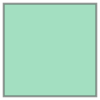

In [38]:
lat_long_geometry

In [39]:
print(len(new_unit_df))
print(error_count)

6329
7


In [40]:
for idx_unit, row_unit in new_unit_df.iterrows():
    year = row_unit['year']
    year_zipcode = row_unit['zip_year_bin']
    bg_id = row_unit['censusBlockGroupFips']
    bg_geometry = row_unit['geometry_BG']
    tract_id = row_unit['censusTract']
    tract_geometry = row_unit['geometry_tract']
    county_id = row_unit['countyCode']
    county_geometry = row_unit['geometry_county']
    state = row_unit['state']
    state_geometry = row_unit['geometry_state']
    lat_long_geometry = row_unit['geometry_lat_long']
    lat = row_unit['latitude']
    long = row_unit['longitude']
    zipcode_geometry = row_unit['geometry_zipcode']
    zipcode = row_unit['reportedZipCode']
    

    intersection_geometry = lat_long_geometry.intersection(zipcode_geometry).intersection(county_geometry).intersection(state_geometry).intersection(tract_geometry)

    if intersection_geometry is None or intersection_geometry.is_empty:
        new_unit_df.at[idx_unit, 'cbgInconsistent'] = 0
    else:
        new_unit_df.at[idx_unit, 'cbgInconsistent'] = 1

In [41]:
new_unit_df['cbgInconsistent'].sum()

649

In [42]:
for idx_unit, row_unit in new_unit_df.iterrows():
    year = row_unit['year']
    year_zipcode = row_unit['zip_year_bin']
    bg_id = row_unit['censusBlockGroupFips']
    bg_geometry = row_unit['geometry_BG']
    tract_id = row_unit['censusTract']
    tract_geometry = row_unit['geometry_tract']
    county_id = row_unit['countyCode']
    county_geometry = row_unit['geometry_county']
    state = row_unit['state']
    state_geometry = row_unit['geometry_state']
    lat_long_geometry = row_unit['geometry_lat_long']
    lat = row_unit['latitude']
    long = row_unit['longitude']
    zipcode_geometry = row_unit['geometry_zipcode']
    zipcode = row_unit['reportedZipCode']
    

    intersection_geometry = bg_geometry.intersection(zipcode_geometry).intersection(county_geometry).intersection(state_geometry).intersection(lat_long_geometry)

    if intersection_geometry is None or intersection_geometry.is_empty:
        new_unit_df.at[idx_unit,'tractInconsistent'] = 0
    else:
        new_unit_df.at[idx_unit,'tractInconsistent'] = 1

In [43]:
new_unit_df['tractInconsistent'].sum()

5

In [44]:
for idx_unit, row_unit in new_unit_df.iterrows():
    year = row_unit['year']
    bg_id = row_unit['censusBlockGroupFips']
    bg_geometry = row_unit['geometry_BG']
    tract_id = row_unit['censusTract']
    tract_geometry = row_unit['geometry_tract']
    county_id = row_unit['countyCode']
    county_geometry = row_unit['geometry_county']
    state = row_unit['state']
    state_geometry = row_unit['geometry_state']
    lat_long_geometry = row_unit['geometry_lat_long']
    lat = row_unit['latitude']
    long = row_unit['longitude']
    zipcode_geometry = row_unit['geometry_zipcode']
    zipcode = row_unit['reportedZipCode']
    

    intersection_geometry = bg_geometry.intersection(zipcode_geometry).intersection(tract_geometry).intersection(state_geometry).intersection(lat_long_geometry)

    if intersection_geometry is None or intersection_geometry.is_empty:
        new_unit_df.at[idx_unit,'countyInconsistent'] = 0
    else:
        new_unit_df.at[idx_unit,'countyInconsistent'] = 1

In [45]:
new_unit_df['countyInconsistent'].sum()

3

In [46]:
for idx_unit, row_unit in new_unit_df.iterrows():
    year = row_unit['year']
    bg_id = row_unit['censusBlockGroupFips']
    bg_geometry = row_unit['geometry_BG']
    tract_id = row_unit['censusTract']
    tract_geometry = row_unit['geometry_tract']
    county_id = row_unit['countyCode']
    county_geometry = row_unit['geometry_county']
    state = row_unit['state']
    state_geometry = row_unit['geometry_state']
    lat_long_geometry = row_unit['geometry_lat_long']
    lat = row_unit['latitude']
    long = row_unit['longitude']
    zipcode_geometry = row_unit['geometry_zipcode']
    zipcode = row_unit['reportedZipCode']
    

    intersection_geometry = bg_geometry.intersection(zipcode_geometry).intersection(tract_geometry).intersection(county_geometry).intersection(lat_long_geometry)

    if intersection_geometry is None or intersection_geometry.is_empty:
        new_unit_df.at[idx_unit,'stateInconsistent'] = 0
    else:
        new_unit_df.at[idx_unit,'stateInconsistent'] = 1

In [47]:
new_unit_df['stateInconsistent'].sum()

12

In [48]:
for idx_unit, row_unit in new_unit_df.iterrows():
    year = row_unit['year']
    bg_id = row_unit['censusBlockGroupFips']
    bg_geometry = row_unit['geometry_BG']
    tract_id = row_unit['censusTract']
    tract_geometry = row_unit['geometry_tract']
    county_id = row_unit['countyCode']
    county_geometry = row_unit['geometry_county']
    state = row_unit['state']
    state_geometry = row_unit['geometry_state']
    lat_long_geometry = row_unit['geometry_lat_long']
    lat = row_unit['latitude']
    long = row_unit['longitude']
    zipcode_geometry = row_unit['geometry_zipcode']
    zipcode = row_unit['reportedZipCode']
    

    intersection_geometry = bg_geometry.intersection(zipcode_geometry).intersection(tract_geometry).intersection(county_geometry).intersection(state_geometry)

    if intersection_geometry is None or intersection_geometry.is_empty:
        new_unit_df.at[idx_unit,'latlongInconsistent'] = 0
    else:
        new_unit_df.at[idx_unit,'latlongInconsistent'] = 1

In [49]:
new_unit_df['latlongInconsistent'].sum()

567

In [50]:
for idx_unit, row_unit in new_unit_df.iterrows():
    year = row_unit['year']
    bg_id = row_unit['censusBlockGroupFips']
    bg_geometry = row_unit['geometry_BG']
    tract_id = row_unit['censusTract']
    tract_geometry = row_unit['geometry_tract']
    county_id = row_unit['countyCode']
    county_geometry = row_unit['geometry_county']
    state = row_unit['state']
    state_geometry = row_unit['geometry_state']
    lat_long_geometry = row_unit['geometry_lat_long']
    lat = row_unit['latitude']
    long = row_unit['longitude']
    zipcode_geometry = row_unit['geometry_zipcode']
    zipcode = row_unit['reportedZipCode']
    

    intersection_geometry = bg_geometry.intersection(lat_long_geometry).intersection(tract_geometry).intersection(county_geometry).intersection(state_geometry)

    if intersection_geometry is None or intersection_geometry.is_empty:
        new_unit_df.at[idx_unit,'zipInconsistent'] = 0
    else:
        new_unit_df.at[idx_unit,'zipInconsistent'] = 1

In [51]:
print(new_unit_df['zipInconsistent'].sum())

6227.0


In [52]:
mask = (new_unit_df['latlongInconsistent'] +  new_unit_df['zipInconsistent']+ new_unit_df['stateInconsistent'] + new_unit_df['countyInconsistent'] + new_unit_df['tractInconsistent'] + new_unit_df['cbgInconsistent']) > 1
new_unit_df.loc[mask, 'multiple'] = 1
new_unit_df.loc[~mask, 'multiple'] = 0

print(sum(new_unit_df['multiple']))

1087


In [53]:
new_unit_df.head()

,reportedZipCode,countyCode,censusTract,censusBlockGroupFips,latitude,longitude,year,state,geometry_zipcode,geometry_county,geometry_tract,geometry_BG,geometry_lat_long,geometry_state,cbgInconsistent,tractInconsistent,countyInconsistent,stateInconsistent,latlongInconsistent,multiple,noOverlap,oneWrong,zipInconsistent
0,28646,37011,37011930200,370119302003,36.0,-81.9,2000,NC,"MULTIPOLYGON (((-81.856157 36.087607, -81.8561...","POLYGON ((-82.016572 36.145136, -82.016446 36....","POLYGON ((-81.920901 36.06335, -81.92059499999...","POLYGON ((-81.884216 36.050656, -81.884332 36....","POLYGON ((-81.95 35.95, -81.85000000000001 35....","MULTIPOLYGON (((-75.726807 35.935844, -75.7182...",1,0,0,0,1,1,NaN,NaN,1.0
1,77550,48167,48167726100,481677261001,29.2,-95.0,2000,TX,"POLYGON ((-94.81155299999999 29.276833, -94.81...","POLYGON ((-95.11995499999999 29.29611, -95.125...","POLYGON ((-95.12993499999999 29.085618, -95.12...","POLYGON ((-95.021345 29.234171, -95.0212009999...","POLYGON ((-95.05 29.15, -94.95 29.15, -94.95 2...","MULTIPOLYGON (((-94.718296 29.728855, -94.7172...",0,0,0,0,0,0,NaN,NaN,1.0
2,77553,48167,48167723900,481677239002,29.4,-94.7,2000,TX,"POLYGON ((-94.802748 29.348501, -94.801019 29....","POLYGON ((-95.11995499999999 29.29611, -95.125...","POLYGON ((-94.569902 29.573206, -94.569824 29....","POLYGON ((-94.78513799999999 29.357124, -94.78...","POLYGON ((-94.75 29.349999999999998, -94.65 29...","MULTIPOLYGON (((-94.718296 29.728855, -94.7172...",0,0,0,0,0,0,NaN,NaN,1.0
3,32503,12033,12033002500,120330025001,30.3,-87.1,2000,FL,"POLYGON ((-87.199598 30.451037, -87.199513 30....","POLYGON ((-87.440343 30.690352999999998, -87.4...","POLYGON ((-86.919135 30.367646999999998, -86.9...","POLYGON ((-87.19211299999999 30.324032, -87.19...","POLYGON ((-87.14999999999999 30.25, -87.05 30....","MULTIPOLYGON (((-80.627171 25.000401, -80.6260...",0,0,0,0,0,0,NaN,NaN,1.0
4,32503,12033,12033002500,120330025001,30.3,-87.1,2000,FL,"POLYGON ((-87.199598 30.451037, -87.199513 30....","POLYGON ((-87.440343 30.690352999999998, -87.4...","POLYGON ((-86.919135 30.367646999999998, -86.9...","POLYGON ((-87.19211299999999 30.324032, -87.19...","POLYGON ((-87.14999999999999 30.25, -87.05 30....","MULTIPOLYGON (((-80.627171 25.000401, -80.6260...",0,0,0,0,0,0,NaN,NaN,1.0


In [54]:
condition = (new_unit_df['latlongInconsistent'] + 
             new_unit_df['stateInconsistent'] + 
             new_unit_df['countyInconsistent'] + 
             new_unit_df['tractInconsistent'] + 
             new_unit_df['cbgInconsistent'] +
             new_unit_df['zipInconsistent']) == 0

new_unit_df['noOverlap'] = 0  # Default to 0
new_unit_df.loc[condition, 'noOverlap'] = 1

print(sum(new_unit_df['noOverlap']))

12


In [55]:
condition = (new_unit_df['latlongInconsistent'] + 
             new_unit_df['stateInconsistent'] + 
             new_unit_df['countyInconsistent'] + 
             new_unit_df['tractInconsistent'] + 
             new_unit_df['cbgInconsistent'] +
             new_unit_df['zipInconsistent']) == 1

new_unit_df['oneWrong'] = 0  # Default to 0
new_unit_df.loc[condition, 'oneWrong'] = 1

print(sum(new_unit_df['oneWrong']))


5230


In [56]:
# Initialize the count dictionary for 'Wrong' values
wrong_counts = {
    'lat_long_geometry': 0,
    'state_geometry': 0,
    'county_geometry': 0,
    'tract_geometry': 0,
    'bg_geometry': 0,
    'zip_geometry': 0  # added for zip codes
}

# Iterate through the DataFrame
for idx_unit, row_unit in new_unit_df.iterrows():
    if row_unit['oneWrong'] == 1:
        if row_unit['latlongInconsistent'] == 1:
            new_unit_df.at[idx_unit, 'lat_long_geometry'] = 'Wrong'
            wrong_counts['lat_long_geometry'] += 1
        if row_unit['stateInconsistent'] == 1:
            new_unit_df.at[idx_unit, 'state_geometry'] = 'Wrong'
            wrong_counts['state_geometry'] += 1
        if row_unit['countyInconsistent'] == 1:
            new_unit_df.at[idx_unit, 'county_geometry'] = 'Wrong'
            wrong_counts['county_geometry'] += 1
        if row_unit['tractInconsistent'] == 1:
            new_unit_df.at[idx_unit, 'tract_geometry'] = 'Wrong'
            wrong_counts['tract_geometry'] += 1
        if row_unit['cbgInconsistent'] == 1:
            new_unit_df.at[idx_unit, 'bg_geometry'] = 'Wrong'
            wrong_counts['bg_geometry'] += 1
        if row_unit['zipInconsistent'] == 1:  # added for zip codes
            new_unit_df.at[idx_unit, 'zip_geometry'] = 'Wrong'
            wrong_counts['zip_geometry'] += 1

# Print the 'Wrong' counts
for category, count in wrong_counts.items():
    print(f"{category}: {count} 'Wrong' values")


lat_long_geometry: 21 'Wrong' values
state_geometry: 0 'Wrong' values
county_geometry: 0 'Wrong' values
tract_geometry: 0 'Wrong' values
bg_geometry: 24 'Wrong' values
zip_geometry: 5185 'Wrong' values


In [57]:
new_unit_df['CBG_Zip_Mutually_Inconsistent'] = np.where(
    (new_unit_df['latlongInconsistent'] == 0) & 
    (new_unit_df['cbgInconsistent'] == 1) & 
    (new_unit_df['zipInconsistent'] == 1), 1, 0)

In [58]:
sum(new_unit_df['CBG_Zip_Mutually_Inconsistent'] == 1)

535

In [59]:
len(new_unit_df[(new_unit_df['latlongInconsistent'] == 1) &(new_unit_df['cbgInconsistent'] == 1) & ((new_unit_df['latlongInconsistent'] + 
             new_unit_df['stateInconsistent'] + 
             new_unit_df['countyInconsistent'] + 
             new_unit_df['tractInconsistent'] + 
             new_unit_df['cbgInconsistent'] +
             new_unit_df['zipInconsistent'])  == 2)])

44

In [60]:
sum(new_unit_df['latlongInconsistent'] == 1)

567

In [61]:
new_unit_df.columns

Index(['reportedZipCode', 'countyCode', 'censusTract', 'censusBlockGroupFips',
       'latitude', 'longitude', 'year', 'state', 'geometry_zipcode',
       'geometry_county', 'geometry_tract', 'geometry_BG', 'geometry_lat_long',
       'geometry_state', 'cbgInconsistent', 'tractInconsistent',
       'countyInconsistent', 'stateInconsistent', 'latlongInconsistent',
       'multiple', 'noOverlap', 'oneWrong', 'zipInconsistent', 'zip_geometry',
       'lat_long_geometry', 'bg_geometry', 'CBG_Zip_Mutually_Inconsistent'],
      dtype='object')

In [62]:
columns_to_drop = [
    'geometry_tract', 'geometry_BG', 'geometry_zipcode',
    'geometry_county', 'geometry_state', 'geometry_lat_long'
]

# Drop the columns
new_unit_df = new_unit_df.drop(columns= columns_to_drop)

In [63]:
# Convert 'zipInconsistent' column to integer type.
new_unit_df['zipInconsistent'] = new_unit_df['zipInconsistent'].astype(int)

# Save to CSV without index.
new_unit_df.to_parquet(r'C:\Users\jorda\Box\Flood Damage PredictionProject\Dataset\InconsistencyDataframes\inconsistency_dataframe_1.parquet.gzip', compression = 'gzip',  index=False)

In [64]:
len(new_unit_df)

6329

In [65]:
# Check for duplicates
duplicates = new_unit_df[new_unit_df.duplicated(keep=False)]

print(duplicates)

     reportedZipCode countyCode  censusTract censusBlockGroupFips  latitude  \
1              77550      48167  48167726100         481677261001      29.2   
3              32503      12033  12033002500         120330025001      30.3   
4              32503      12033  12033002500         120330025001      30.3   
7              77096      48201  48201412500         482014125002      29.7   
8              77551      48167  48167726100         481677261001      29.2   
...              ...        ...          ...                  ...       ...   
6269           41666      21071  21071920700         210719207002      37.4   
6288           33311      12011  12011041801         120110418012      26.1   
6289           33315      12011  12011043002         120110430026      26.1   
6319           01841      25009  25009253201         250092532012      42.7   
6324           33924      12071  12071080100         120710801002      26.7   

      longitude  year state cbgInconsistent tractIn